In [1]:
import torch
import random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=True, download=True,
                    transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=False, transform=transforms.ToTensor()),
    batch_size=1
)

Files already downloaded and verified


In [3]:
import math

def size_output_conv(Width, Height, layer):
    """
    W_in: Width input
    H_in: Height input
    O: Out channels
    K: Kernel size
    P: padding
    S: Stride
    """
    O = layer.out_channels
    K = layer.kernel_size[0]
    P = layer.padding[0]
    S = layer.stride[0]
    W_out = math.floor(((Width - K + 2*P) / S) + 1)
    H_out = math.floor(((Height - K + 2*P) / S) + 1)
    Out_channels = O
    return (Out_channels, W_out, H_out)

In [20]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size = 2, stride = 2, padding = 1),
            # nn.MaxPool2d(2, stride=2)
            nn.Conv2d(16, 8, kernel_size = 2, stride = 2, padding = 1)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size = 2, stride = 2, padding = 1),
            nn.ConvTranspose2d(16, 3, kernel_size = 2, stride = 2, padding = 1),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [21]:
model = Autoencoder()
model.cuda()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(16, 8, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (1): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  )
)

In torch.Size([3, 32, 32])
Out torch.Size([3, 30, 30])


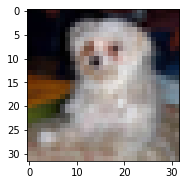

In [22]:
batch_data = next(iter(train_loader))
img = batch_data[0][0]
print(f"In {img.shape}")
img = transforms.ToPILImage()(img)
img = np.array(img)
plt.subplot(121)
plt.imshow(img)

imgs = batch_data[0].to(device)
out = model(imgs)[0]
print(f"Out {out.shape}")
# out = transforms.ToPILImage()(out)
# out = np.array(out)
# plt.subplot(122)
# plt.imshow(out)

In [6]:
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10

for epoch in range(n_epochs):
    train_loss = 0.0

    for images, labels in train_loader:
        images = images.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    
     # Validation
    valid_loss = 0.0
    model.eval() 
    for images, labels in test_loader:
        images = images.cuda()
        outputs = model(images)
        loss = criterion(outputs, images)
        valid_loss += loss.item()*images.size(0)

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(test_loader)}')

Epoch 1 		 Training Loss: 0.29029252975094666 		 Validation Loss: 0.0005992103386128293
Epoch 2 		 Training Loss: 0.01150733523707782 		 Validation Loss: 0.0002057393324360419
Epoch 3 		 Training Loss: 0.0039177369284643165 		 Validation Loss: 6.616296046532852e-05
Epoch 4 		 Training Loss: 0.0014173013003369029 		 Validation Loss: 2.8082688667947765e-05
Epoch 5 		 Training Loss: 0.0005617710906807473 		 Validation Loss: 1.1437113323941616e-05
Epoch 6 		 Training Loss: 0.00018360729301068648 		 Validation Loss: 3.6481423332929806e-06
Epoch 7 		 Training Loss: 6.691908903055904e-05 		 Validation Loss: 1.1716550331837716e-06
Epoch 8 		 Training Loss: 3.46528257776291e-05 		 Validation Loss: 3.3283732373547535e-06
Epoch 9 		 Training Loss: 2.1288157502798056e-05 		 Validation Loss: 4.7560186868622623e-07
Epoch 10 		 Training Loss: 1.188384095408789e-05 		 Validation Loss: 1.8593672207938282e-07


In torch.Size([3, 32, 32])
Out torch.Size([3, 32, 32])


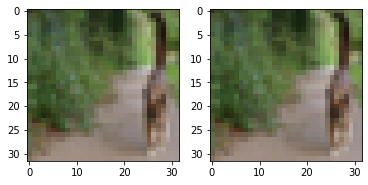

In [12]:
batch_data = next(iter(train_loader))
img = batch_data[0][0]
print(f"In {img.shape}")
img = transforms.ToPILImage()(img)
img = np.array(img)
plt.subplot(121)
plt.imshow(img)

imgs = batch_data[0].to(device)
out = model(imgs)[0]
print(f"Out {out.shape}")
out = transforms.ToPILImage()(out)
out = np.array(out)
plt.subplot(122)
plt.imshow(out)